In [2]:
from __future__ import annotations

import datetime
import math
import xml.etree.ElementTree as ET
from common import load_csv, Route, Checkpoint, solar_power_out, heversine_and_azimuth
from sklearn.linear_model import LinearRegression
import numpy as np
import time

In [3]:
#constants
CELL_AREA = 0.0153 #m^2

In [4]:
#absolute cell tilts 
tilts = {
    "hood_front": {
        "left_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "left_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44]
    },
    "top_front": {
        "leftmost_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftmost_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftmost_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "leftcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "rightcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightmost_top_4x3": [28.52, 28.52, 28.52, 28.52, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightmost_bottom_4x3": [22.16, 22.16, 22.16, 22.16, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14]
    },
    "top_back": {
        "leftmost_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "leftcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightmost_4x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64, -3.64]
    },
    "back": {
        "leftmost_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_top_4x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftmost_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64], 
        "rightcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_bottom-4x4": [-4, -4, -4, -4, -5, -5, -5, -5, -6, -6, -6, -6]
    }
}

In [5]:
from astral import LocationInfo
from astral.sun import azimuth,elevation
class CellSolarData:
    def __init__(self, coord: Checkpoint, time: datetime.datetime, tilt: float):
        l = LocationInfo()
        l.name = f'{coord.lat},{coord.lon}'
        l.region = 'United States'
        l.timezone = 'US/Central' #update to be dynamic
        l.latitude = coord.lat
        l.longitude = coord.lon
        self.heading_azimuth_angle = coord.azimuth
        self.heading_azimuth_angle = 180 + self.heading_azimuth_angle if tilt < 0 else self.heading_azimuth_angle
        self.heading_azimuth_angle %= 360
        self.tilt = tilt * -1 if tilt < 0 else tilt
        self.lat = coord.lat
        self.lon = coord.lon
        self.elevation = coord.elevation / 1000 #convert to km
        self.time = time
        self.sun_elevation_angle = elevation(l.observer, time)
        self.sun_elevation_angle = max(0, self.sun_elevation_angle)
        self.sun_azimuth_angle = azimuth(l.observer, time)
        self.air_mass = 1/(math.cos(math.radians(90-self.sun_elevation_angle)) + 0.50572*(96.07995-(90-self.sun_elevation_angle))**-1.6364)
        self.incident_diffuse = 1.1*1.353*((1-0.14*(self.elevation / 1000))*0.7**self.air_mass**0.678 + 0.14*(self.elevation / 1000)) 
        self.cell_diffuse = self.incident_diffuse*(math.cos(math.radians(self.sun_elevation_angle))*math.sin(math.radians(self.tilt))*math.cos(math.radians(self.heading_azimuth_angle - self.sun_azimuth_angle)) + math.sin(math.radians(self.sun_elevation_angle))*math.cos(math.radians(self.tilt)))
        self.cell_irradiance = self.cell_diffuse * 1000 #convert to watts/m^2
        self.cloud_cover = coord.cloud_cover / 100
        cell_power_out = solar_power_out(self.cell_irradiance, self.cloud_cover) * CELL_AREA #watts
        if isinstance(self.incident_diffuse, complex):
            print(self.air_mass, self.incident_diffuse, self.sun_elevation_angle, self.tilt, self.heading_azimuth_angle, self.sun_azimuth_angle, time)
        self.cell_power_out = cell_power_out if cell_power_out > 0 else 0
    

In [6]:
def section_solar_power_out(coord: Checkpoint, time: datetime.datetime, section_tilts: dict):
    section_irradiance_sum = 0
    tilt_irradiances: dict[float, CellSolarData] = {}
    for array in section_tilts.keys():
        array_sum = 0
        for cell_angle in section_tilts[array]:
            if(cell_angle in tilt_irradiances):
                array_sum += tilt_irradiances[cell_angle].cell_power_out
            else:
                cell = CellSolarData(coord, time, cell_angle)
                
                # if(cell_angle<0):
                #     print(cell_angle)
                #     print(coord.azimuth)
                #     print(cell.__dict__)
                tilt_irradiances[cell_angle] = cell
                array_sum += cell.cell_power_out
        section_irradiance_sum += array_sum
    #watts
    return section_irradiance_sum

def total_solar_power_out(coord: Checkpoint, time: datetime.datetime, tilts: dict):
    # iterating over all of the sections in the car
    car_power_sum: float = 0
    for section in tilts.keys():
        car_power_sum += section_solar_power_out(coord, time, tilts[section])
    #watts
    return car_power_sum

    #sum of all the modules on the car
from pytz import timezone
cen = timezone("US/Central")
est = timezone("US/Eastern")
utc = timezone("UTC")

def energy_captured_along_route_vconst(time_initial: datetime.datetime, velocity: float, route: Route):
    current_time = time_initial
    total_energy = 0
    velocity_ms = velocity / 3.6 #convert to m/2
    power_list = []
    for i in range(len(route.checkpoints)-1):
        segment_distance = route.checkpoints[i+1].distance if i==0 else route.checkpoints[i+1].distance - route.checkpoints[i].distance

        segment_time = segment_distance/velocity_ms

        total_power_in_current = total_solar_power_out(route.checkpoints[i], current_time, tilts=tilts)
        current_time += datetime.timedelta(seconds=segment_time)
        total_power_in_next = total_solar_power_out(route.checkpoints[i+1], current_time, tilts=tilts)
        total_power_in_avg = (total_power_in_current + total_power_in_next) / 2
        power_list.append(total_power_in_avg)
        total_energy += total_power_in_avg*segment_time #watt seconds
   
    print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return (total_energy/3600, power_list) #in watt hours

def energy_captured_between_points(c1: Checkpoint, current_time: datetime.datetime, segment_time: int):
    total_power_in_curr = total_solar_power_out(c1, current_time, tilts=tilts)
    energy_this_segment = total_power_in_curr * segment_time / 3600 #wh
    return energy_this_segment

def energy_captured_along_route(time_initial: datetime.datetime, velocities: list[float], route: Route):
    current_time = time_initial
    total_energy = 0
    
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2

        segment_distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance

        segment_time = segment_distance / v_avg_ms
        energy_this_segment = energy_captured_between_points(route.checkpoints[i-1], current_time, segment_time)
        current_time += datetime.timedelta(seconds=segment_time)
        power_per_checkpoint.append(energy_this_segment * 3600 / segment_time) 
        total_energy += energy_this_segment #watt hours
   
    # print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    # print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return total_energy, power_per_checkpoint #in watt hours, watts


In [7]:
#for independence to topeka, 2022
speed_limits = { #distance and speed in mph
    0: 20, #distance: speed limit
    1: 30,
    1.6: 35,
    7.1: 30,
    7.6: 25,
    7.9: 30,
    8.7: 40,
    16.7: 35,
    18.5: 45,
    20.1: 40,
    24.2: 35,
    24.5: 45,
    34.5: 50,
    38.5: 30,
    38.7: 50,
    43.3: 40,
    44.3: 30,
    44.6: 35,
    45.6: 40,
    46: 45,
    55.7: 55,
    60.4: 45,
    61.6: 55,
    69.6: 45,
    70.2: 60,
    76.6: 55,
    86.5: 45,
    87: 55,
    93.9: 45,
    94.9: 40,
    96: 30,
    97: 40,
    98: 30,
    98.25: 25
}

In [8]:
air_density = 1.204 #kg/m^3
coef_drag = 0.19
coef_rr = 0.0023
car_mass = 575 #kg
accel_g = 9.81 #m/s^2
wheel_radius = 0.2 #m
wind_speed = 0 #km/h
cross_section = 2.21 #m^2


def calculate_work(grad: float, speed_initial: float, speed_end: float, time: float):
    # _speed_0 = 0.277777778*speed_initial #m/s
    # _speed_1 = 0.277777778*speed_end #m/s
    _speed_0 = speed_initial
    _speed_1 = speed_end
    accel = (_speed_1 - _speed_0) / time
    force_rr = coef_rr*car_mass*accel_g*math.cos(grad)
    force_drag = 0.5*air_density*coef_drag*((_speed_0 + _speed_1)/2 + wind_speed)**2
    force_grad = car_mass*accel_g*math.sin(grad)
    force_accel = car_mass*accel
    accel_distance = time*_speed_0 + (accel*time**2)/2
    force_tractive = force_rr + force_drag + force_grad + force_accel
    work = accel_distance * force_tractive 

    return work #J

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
def predict_average_electrical_power(avg_tractive_power: float):
    efficiencyDataX = np.array([0, 16.688, 152.532, 246.05, 335.306, 423.94, 513.536, 677.019,
    840.528, 996.03, 1147.608, 1278.624, 1405.316, 1537.61, 1783.478, 1974.78])
    efficiencyDataY = np.array([0, 28, 171, 266, 359, 451, 544, 721, 898, 1071, 1242, 1402, 1558, 1718, 2069, 2385])
    
    degree = 3
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(efficiencyDataX.reshape(-1,1), efficiencyDataY)
    # import matplotlib.pyplot as plt
    # X_seq = np.linspace(min(efficiencyDataX), max(efficiencyDataX), 300).reshape(-1, 1)
    # plt.figure()
    # plt.scatter(efficiencyDataX,efficiencyDataY)
    # plt.plot(X_seq,polyreg.predict(X_seq),color="black")
    # plt.title("Polynomial regression with degree "+str(degree))
    # plt.show()
    avg_electrical_power = polyreg.predict(np.array([avg_tractive_power]).reshape((-1,1)))
    return avg_electrical_power[0] #Watts

predict_average_electrical_power(0)

3.3019831949337686

In [10]:
def solve_for_gradient(delta_elev, delta_d):
    c = math.sqrt(delta_d**2 + delta_elev**2)
    return math.asin(delta_elev/c)

In [11]:
def energy_used_between_points(c1: Checkpoint, c2: Checkpoint, speed_initial: float, speed_end: float, time: float):
    theta = solve_for_gradient(c2.elevation - c1.elevation, c2.distance - c1.distance)
    work = calculate_work(theta, speed_initial, speed_end, time)
    avg_tractive_power = work / time
    if avg_tractive_power <= 0:
        regen_efficiency = 0.05
        avg_electrical_power = avg_tractive_power * regen_efficiency
    else:
        avg_electrical_power = predict_average_electrical_power(avg_tractive_power)
    
    electrical_energy = avg_electrical_power * time
    passive_consumption = 10 #W
    electrical_energy += passive_consumption * time
    # print(f'theta: {math.degrees(theta)}, tractive: {avg_tractive_power}, elec: {avg_electrical_power}')
    return electrical_energy, avg_electrical_power, avg_tractive_power

def energy_used_along_route(route: Route, velocities: list[float]):
    total_energy = 0
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2
        time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / v_avg_ms
        energy_used, avg_electrical_power, _ = energy_used_between_points(route.checkpoints[i-1], route.checkpoints[i], old_speed, new_speed, time)
        power_per_checkpoint.append(avg_electrical_power)
        total_energy += energy_used
        # print(energy_used/3600)
    total_energy /= 3600
    return total_energy, power_per_checkpoint #wH


In [12]:
def solve_for_time(current_velocity: float, accel: float, distance: float):
    assert current_velocity**2 + 2*accel*distance < 0
    time = (-current_velocity + math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel #s
    if time < 0:
        time = (-current_velocity - math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel 
    return time
def average_velocity(route: Route, velocities: list[float]):
    times = []
    total_time = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            avg_v = (velocities[i] + velocities[i-1])/2
            time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / avg_v
            times.append(time)
            total_time += time
    v_avg = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            v_avg += velocities[i-1] * times[i-1] / total_time
    return v_avg


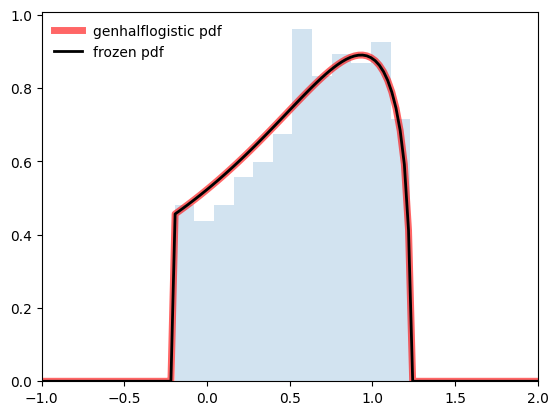

In [13]:

from scipy.stats import genhalflogistic
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
a = 0.77
mean, var, skew, kurt = genhalflogistic.stats(a, moments='mvsk')
loc = -0.2
scale = 1.1
x = np.linspace(-1, 2, 120)
ax.plot(x, genhalflogistic.pdf(x,a,loc=loc, scale=scale), 'r-', lw=5, alpha=0.6, label='genhalflogistic pdf')
rv = genhalflogistic(a, loc=loc, scale=scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = genhalflogistic.ppf([0.001, 0.5, 0.999], a, loc=loc,scale=scale)
np.allclose([0.001, 0.5, 0.999], genhalflogistic.cdf(vals, a, loc=loc, scale=scale))
r = genhalflogistic.rvs(a, size=1000, loc=loc, scale=scale)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([-1, 2])
ax.legend(loc='best', frameon=False)
plt.show()
#goal is to find acceleration that results in lowest power value.
def simulate_power_used(c1, c2, speed_initial, distance, current_speed_limit, trials=5):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    while(current_trial < trials):
        r1 = genhalflogistic.rvs(0.77, size=1, loc=-0.35, scale=1.25)
        speed_range = current_speed_limit - speed_initial
        speed_final_sample = r1[0] * speed_range + speed_initial
        if(speed_final_sample < 0):
            continue
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            _, avg_elec_power, avg_tractive_power = energy_used_between_points(c1, c2, speed_initial, speed_final_sample, time)
            eff = avg_tractive_power / avg_elec_power if avg_elec_power > 0 else avg_elec_power / avg_tractive_power
            score_i = eff

            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                if score_i >= 0.3:
                    current_trial += 1
                total_trials +=1
                if(score_i > 0.85):
                    break
            else:
                total_trials +=1
            if total_trials > 50:
                break

            # print(f"Trial {current_trial}: Eff {round(eff,2) * 100}%, a_calc: {a_calc}, distance: {distance}, elec: {avg_elec_power}, trac: {avg_tractive_power}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    if score < 0.2:
        print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f

In [14]:
def simulate_energy_captured(c: Checkpoint, distance: float, current_time: datetime.datetime, speed_initial: float, current_speed_limit: float, trials=10):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    t = 0
    while(current_trial < trials):
        r1 = genhalflogistic.rvs(0.77, size=1, loc=-0.35, scale=1.25)
        speed_range = current_speed_limit - speed_initial
        speed_final_sample = r1[0] * speed_range + speed_initial
        if(speed_final_sample <= 0):
            continue
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            energy_in = energy_captured_between_points(c, current_time, time)

            score_i: float = energy_in
            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                t = time
                current_trial += 1
                total_trials += 1
            else:
                total_trials += 1
            if total_trials > 50:
                break

            # print(f"Trial {current_trial}: Score {round(score_i,2)}, a_calc: {a_calc}, distance: {distance}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f,t

In [15]:
def assign_velocities(route: Route, time_initial:datetime.datetime, speed_limits: dict):
    current_time = time_initial
    #assert average_velocity > 35 mph
    velocities = [0]
    j = 0
    speed_limit_keys = list(speed_limits.keys())
    for i in range(1, len(route.checkpoints) - 1):
        if (j < len(speed_limits.keys())):
            speed_limit_ends_at = speed_limit_keys[j+1] * 1.60934
            if(route.checkpoints[i].distance / 1000 >= speed_limit_ends_at):
                j+=1
        if i == 0:
            velocities.append(0)
        else:
            current_speed_limit = speed_limits[speed_limit_keys[j]] * 1.60934 / 3.6#convert to m/s
            distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance #meters
            current_velocity = velocities[i-1] / 3.6
            start = time.time()
            _, final_velocity = simulate_power_used(route.checkpoints[i-1], route.checkpoints[i], current_velocity, distance, current_speed_limit)
            _, final_velocity_2, _ = simulate_energy_captured(route.checkpoints[i-1], distance, current_time, current_velocity, current_speed_limit)
            end= time.time()
            weighted_v = final_velocity * 0.9 + final_velocity_2 * 0.1
            t = distance / weighted_v
            print(f'{(end-start)*1000} ms')
            current_time += datetime.timedelta(seconds=t)
            velocities.append(weighted_v * 3.6)
    velocities.append(0)
    return velocities

In [22]:
route = load_csv("A. Independence to Topeka")
loc_dt = datetime.datetime(2023, 6, 1, 8, 0, 0, tzinfo=est)
utc_dt = loc_dt.astimezone(utc)

velocities = assign_velocities(route, loc_dt, speed_limits)
avg_v = average_velocity(route, velocities)
print("avg v: ", avg_v)


Total Trials 51. Score: 2.665496090576582, a: 0.0016373971161135778
48.009395599365234 ms
Total Trials 51. Score: 0.4380639946429504, a: -0.09741714909747015
34.995317459106445 ms
Total Trials 51. Score: 0.22171448001259217, a: -0.10604919129737343
37.015676498413086 ms
Total Trials 51. Score: 0.037065367578881625, a: -0.17612040157652364
45.01509666442871 ms
Total Trials 51. Score: 0.028433930735784572, a: -0.15219746815816454
46.00358009338379 ms
Total Trials 51. Score: 0.035495072412488296, a: -0.06022466296779079
38.002967834472656 ms
Total Trials 51. Score: 0.05597015790448506, a: -0.04596255255283192
38.00845146179199 ms
Total Trials 51. Score: 0.10449352628438839, a: -0.030927079845576654
37.02235221862793 ms
Total Trials 51. Score: 0.05000000000000001, a: 0.014894857198238076
Total Trials 51. Score: 0.09989729711312764, a: -0.004670485904353396
37.9941463470459 ms
Total Trials 51. Score: 0.022406021452094957, a: -0.001950150618100307
39.021968841552734 ms
Total Trials 51. Score

In [78]:
e1, power_outs = energy_used_along_route(route, velocities)
print("energy used (wh): ", e1)
e2, power_ins = energy_captured_along_route(utc_dt, velocities, route)
print("energy captured (wh): ", e2)
print(max(power_outs), min(power_outs), max(power_ins), min(power_ins))
print(len(route.checkpoints), len(power_ins), len(power_outs), len(velocities))

NameError: name 'route' is not defined

In [ ]:
import folium
import branca.colormap
import pandas as pd
def route_to_list(route: Route):
    coords: list[tuple[float, float]] = [] 
    for checkpoint in route.checkpoints:
        coords.append((checkpoint.lat, checkpoint.lon))
    return coords

def create_map(route: Route, values: list, diverging = True):
    coords = route_to_list(route)
    m = folium.Map()
    if diverging:
        colors: list = branca.colormap.linear.RdYlGn_04.colors
        colors.reverse()
        colormap = branca.colormap.LinearColormap(colors=colors, vmin=min(values), vmax=max(values))
    else:
        colormap = branca.colormap.linear.YlGnBu_07.scale(min(values), max(values)).to_step(7)
    tooltip = [f"{str(v)} | Value: {round(values[i])}" for (i,v) in enumerate(route.checkpoints)]
    for i in range(len(coords)-1):
        rgba = colormap.rgba_floats_tuple(values[i])
        rgba_scaled = (round(i*255) for i in rgba[0:3])
        # print('#{:02x}{:02x}{:02x}'.format(*rgba_scaled))
        folium.PolyLine(locations=[coords[i], coords[i+1]], tooltip=tooltip[i], weight=10, color='#{:02x}{:02x}{:02x}'.format(*rgba_scaled)).add_to(m)
    # folium.ColorLine(positions=coords, colormap=colormap, weight=5, colors=power_list).add_to(m)
    # for i,p in zip_longest(power_list, coords, fillvalue=np.mean(power_list)):
    #     folium.Marker(p, tooltip = i).add_to(m)
    df = pd.DataFrame(coords).rename(columns={0: 'lat', 1: 'lon'})
    sw = df[['lat', 'lon']].min().values.tolist()
    ne = df[['lat', 'lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    m.add_child(colormap)
    return m
# m1 = create_map(route, powers_in)
m = create_map(route, velocities, False)
m

In [18]:
# NEED TO CHANGE FUNCTION SO THAT THE ASSIGN VELOCITIES FUNCTION IS ONLY CALLED ONCE, BECAUSE IT TAKES A LONG TIME TO COMPLETE
# AND SO WHEN REASSIGNING THE VELOCITIES, I DONT CALL THE ASSIGN VELOCITIES FUNCTION AGAIN, INSTEAD I JUST TAKE A SUBLIST OF THE PAST VELOCITIES LIST
# I DO THIS WITHIN THE next_instruction FUNCTION AS WELL AS IN THE find_max_reachable_placemark FUNCTION,
# I HAVE TO ADDITIONALLY PASS IN THE velocities sublist WHICH REPRESENTS THE VELOCITY FOR EVERYPOINT IN THE UNCOVERED ROUTE

def next_instruction(current_time: datetime.datetime, current_charge, current_lat: float, current_lon: float, current_route, speed_limits : dict, checkpoint_close_time: datetime.datetime):
    #route = load_csv(current_route)
    #velocities = assign_velocities(current_route, current_time, speed_limits)

    next_checkpoint = route.checkpoints[-1]
    
    current_index, current_placemark = closest_checkpoint_in_route(current_route, current_lat, current_lon)
    print(current_index, current_placemark)

'''
    uncovered_route = Route('uncovered_route', current_route.checkpoints[current_index:])
    # How is current_energy calculated from the current_charge?
    current_energy = current_charge # This is wrong, but how to fix it?
    need_to_charge, max_reachable_placemark, max_index = find_max_reachable_placemark(current_index, current_time, current_route, current_energy, velocities)
    
    distance_in_between = max_reachable_placemark.distance - current_placemark.distance
    
    #velocities = assign_velocities(Route('max_sub_route', uncovered_route.checkpoints[current_index:max_index]))
    velocities = velocities[current_index:max_index]

    print(len(current_route.checkpoints))
    print(len(velocities))
    
    
    # we assume that the close_time is on the same day as the the current time (note: 24-hour clock so 1:00pm would be 13 for hours)


    # if the estimated amount of time that it will take is less than the amount allowed, then time is not an issue
    if (distance_in_between/average_velocity(current_route, velocities) < close_time - current_time):
        if (need_to_charge):
            print("Go to the following placemark at the following coordinates:", max_reachable_placemark.lat, max_reachable_placemark.lon)
            print("Then charge the vehicle")
        else:
            print("You have enough charge to make it to the next checkpoint, located at:", max_reachable_placemark.lat, max_reachable_placemark.lon)
            print("You will have this much charge left: ", current_charge) # this is wrong I haven't changed the value but how would I find the estimated charge at the end
            # using the energy values? how to convert energy back into charge
            # this function should return the predicted charge and time at the end of completion of this instruction
    else:
        print("You don't have enough time")
        # there are two cases here: you dont have enough charge or time to reach the checkpoint, or you have enough charge but not enough time
        # maybe different velocities are required now'''


def find_max_reachable_placemark(curr_placemark_index, curr_time, route, current_energy, velocities):
    for i in range(max(2, curr_placemark_index), len(route.checkpoints)):
        sub_route = Route('sub_route', route.checkpoints[:i])
        vel = velocities[:i]
        sub_capture = energy_captured_along_route(curr_time, vel, sub_route)
        sub_use = energy_used_along_route(sub_route, vel)
        #vel = assign_velocities(sub_route, curr_time, speed_lim)
        #if (current_energy + energy_captured_along_route(curr_time, sub_route, vel) - energy_used_along_route(sub_route, vel) < 0):
        if (current_energy + sub_capture[0] - sub_use[0] < 0):
            return [True, route.checkpoints[i-1], i]
    #if the for loop ran to completion that means there's enough energy to reach the next checkpoint
    return [False, route.checkpoints[-1], len(route.checkpoints)-1]

def closest_checkpoint_in_route(route, lat, lon):
    #initial placeholder values
    closest_checkpoint = route.checkpoints[0]
    min_distance = heversine_and_azimuth(closest_checkpoint.lon, closest_checkpoint.lat, lon, lat)
    min_index = 0

    for index, curr_checkpoint in enumerate(route.checkpoints):
        distance = heversine_and_azimuth(curr_checkpoint.lon, curr_checkpoint.lat, lon, lat)
        if distance < min_distance:
            min_distance = distance
            min_index = index
            closest_checkpoint = curr_checkpoint
    return index, closest_checkpoint

In [19]:
route = load_csv("A. Independence to Topeka")
point_in_route = route.checkpoints[10]


loc_dt = datetime.datetime(2023, 6, 1, 8, 0, 0, tzinfo=est)
utc_dt = loc_dt.astimezone(utc)

# placeholder close_time value of 1pm, should be changed to the actual close time
close_time = datetime.datetime(2023, 6, 1, 13, 0, 0, tzinfo=est)
# Arguements: time,  charge amount, latitude, longitude, route, speed limits (for assign_velocities function), next checkpoint close time
next_instruction(loc_dt, 60, 39.012275, -94.520919, route, speed_limits, close_time)
#                                                                         ^ this is just a placeholder value, it should be replaced with the actual close time

2573 Lat: 39.009632 | Lon: -94.481922 | Distance: 13947.07 
| Azimuth: 181.3 | Elevation: 96.6 | Cloud Cover: 25 
| Wind Dir: 182.0 | Wind Speed: 12.0


In [150]:
#sub_route = Route('sub_route', [0, 1, 2, 3, 4])
#print((sub_route.checkpoints))
#                                              timezone may need to change based on race loaction


for i in range(9,17):
    date = datetime.datetime(2024, 7, i, 7, 0, 0)
    day_planner(date, 90, 80, 0.05)


The current date is:  09 July 2024
0.8692626480929502
The last index value for this segment is:  2573
The current date is:  10 July 2024
0.4209190653542711
The last index value for this segment is:  2979
The current date is:  11 July 2024
3.9839324769909483
The last index value for this segment is:  1925
The current date is:  12 July 2024
0.41702528756267254
The last index value for this segment is:  3169
The current date is:  13 July 2024
0.6718005744509157
The last index value for this segment is:  1504
The current date is:  14 July 2024
0.9281629030697633
The last index value for this segment is:  2625
The current date is:  15 July 2024
0.6585737044612762
The last index value for this segment is:  1619
The current date is:  16 July 2024
2.5935142323461324
The last index value for this segment is:  2224


In [223]:
date = datetime.datetime(2024, 7, 13, 7, 0, 0)
day_planner(date, 90, 80, 0.05, 18)

The current date is:  13 July 2024
07:00:00 AM | Current Battery charge:   90.00% | Drive to checkpoint start
09:00:00 AM | Current Battery charge:  100.00% | Drive toward Lander stage point
09:44:58 AM | Current Battery charge:    0.59% | You ran out of power at (42.552641, -106.822705). Charge the vehicle to full capacity
10:14:48 AM | Current Battery charge:  100.00% | Charging complete. Drive toward Lander stage point
11:17:43 AM | Current Battery charge:    0.53% | You ran out of power at (42.484342, -107.672001). Charge the vehicle to full capacity
11:47:34 AM | Current Battery charge:  100.00% | Charging complete. Drive toward Lander stage point
12:50:59 PM | Current Battery charge:    0.06% | You ran out of power at (42.696707, -108.57663). Charge the vehicle to full capacity
01:20:58 PM | Current Battery charge:  100.00% | Charging complete. Drive toward Lander stage point
01:38:15 PM | Current Battery charge:   71.35% | Lander stage point has been reached. Now serve 45-min ho

In [222]:
# Rulebook says: 'MOVs are not permitted to perform external energy charging during mandatory hold time' does this mean only solar charging is allowed?
# Assumes that all times are on the same timezone but this may change based on 2024 tour details
# Assumes a singular constant velocity which is definitely not the case, instead needs to use the assign_velocities function
# Assumes a high enough average velocity (80kmph). Don't know whether reaching such speeds is even possible
# Assumes close times are the same for all of the checkpoints which they're not
# Assumes that being too early (before the open time) wont be an issue, i.e. does not check for that outcome
# Always chargees battery capacity to full capacity, there might be some points lost by doing this
# The days are hardcoded in the first if block, this needs to be changed based on 2024 tour details
# Need way to convert energy to amount of battery percentage, at the moment just a 'factor' variable is multiplied 
# For now the only strategy or rule that this follows is that it prioritizes going from
# (stage start to checkpoint)/(checkpoint to checkpoint)/(checkpoint to stage finish)
# over going through an optional loop, so the next checkpoint is reached first, then looping until
# time runs out, this strategy is very very bad for the very first loop which closes at 2pm so this function would tell you to do nothing for the following 4 hours
# Some route values that main_route can take are so large that in order to be able to cover teh distance
# in 9 hours (one day) your average needs to be quite high, like Grand Island to Gering requires 60kmph pretty much
# so probably gering would not be reached and instead the car would stop for the day at half the distance between grand island and casper
# and the next day do the other half, either getting to gering before or after the checkpoint closes (11:30 am of that day)
#                                                                'speed' and 'factor' are just placeholder values, speed is used for the velocity and factor is used for finding the battery charge % decrease based on the energy used and capturedS
def day_planner(date:datetime.datetime, starting_battery_charge, speed, factor, charging_time_in_seconds_per_percent):
    print("The current date is: ", date.strftime("%d %B %Y"))
    battery_charge = starting_battery_charge
    if (date.day == 9):
        main_route = load_csv("A. Independence to Topeka") # Independence is stage 1 start
        optional_route = load_csv("AL. Topeka Loop")
        main_close_time = datetime.datetime(2024, 7, 9, 13, 45, 0)
        loop_close_time = datetime.datetime(2024, 7, 9, 14, 0, 0) # 2pm same day
    elif (date.day == 10):
        main_route = load_csv("B. Topeka to Grand Island")
        optional_route = load_csv("BL. Grand Island Loop")
        main_close_time = datetime.datetime(2024, 7, 10, 18, 0, 0)
        loop_close_time = datetime.datetime(2024, 7, 10, 18, 0, 0) # 6pm same day
    elif (date.day == 11):
        main_route = load_csv("C. Grand Island to Gering") # Grand Island is stage 2 start
        optional_route = load_csv("D. Gering to Casper") # you can try and push to get to casper but you have to see which is more optimal for points, staying at gering and charging, or going toward casper
        main_close_time = datetime.datetime(2024, 7, 11, 18, 0, 0) # the actual checkpoint closes 11:30 am on the 12th but tour day closes 6pm same day
        loop_close_time = datetime.datetime(2024, 7, 11, 18, 0, 0) # NOT USED
    elif (date.day == 12):
        main_route = load_csv("D. Gering to Casper")
        optional_route = load_csv("DL. Casper Loop")
        main_close_time = datetime.datetime(2024, 7, 12, 18, 0, 0) # the actual checkpoint closes 11:30 am on the 13th but tour day closes 6pm same day
        loop_close_time = datetime.datetime(2024, 7, 12, 18, 0, 0) # 6pm same day, however actual stop time for checkpoint is 13th at 11:30 am
    elif (date.day == 13):
        main_route = load_csv("E. Casper to Lander")
        optional_route = load_csv("EL. Lander Loop")
        main_close_time = datetime.datetime(2024, 7, 13, 18, 0, 0)
        loop_close_time = datetime.datetime(2024, 7, 13, 18, 0, 0) # 6pm same day
    elif (date.day == 14):
        main_route = load_csv("F. Lander to Montpelier") # Lander is stage 3 start
        optional_route = load_csv("FL. Montpelier Loop")
        main_close_time = datetime.datetime(2024, 7, 14, 18, 0, 0) # the actual checkpoint closes 12:30 pm on the 15th but tour day closes 6pm same day
        loop_close_time = datetime.datetime(2024, 7, 14, 18, 0, 0) # 6pm same day, however actual stop time for checkpoint is 15th at 12:00 pm
    elif (date.day == 15):
        main_route = load_csv("G. Montpelier to Pocatello")
        optional_route = load_csv("GL. Pocatello Loop")
        main_close_time = datetime.datetime(2024, 7, 15, 18, 0, 0)
        loop_close_time = datetime.datetime(2024, 7, 15, 18, 0, 0) # 6pm same day
    elif (date.day == 16):
        main_route = load_csv("H. Pocatello to Twin Falls")
        optional_route = load_csv("H. Pocatello to Twin Falls") # NOT USED
        main_close_time = datetime.datetime(2024, 7, 16, 15, 0, 0)
        loop_close_time = datetime.datetime(2024, 7, 16, 15, 0, 0) # NOT USED
    else:
        print("Non-race day entered")
        return

    print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", "Drive to stage start" if date.day in {9, 11, 14} else "Drive to checkpoint start")
    
    
    date = date.replace(hour=9, minute=0, second=0)
    battery_charge = 100
    print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"Drive toward {main_route.name.split()[-1]}", "stage point" if date.day in {10, 13, 15} else "checkpoint")
    

    place_holder_kmph = speed # PLACEHOLDER VELOCITY IN KM PER HOUR
    velocities = [place_holder_kmph]*len(main_route.checkpoints)# TO BE REPLACED WITH THE ASSIGN VELOCITIES FUNCTION
    average_velocity = speed # TO BE REPLACED WITH THE AVERAGE VELOCITIES FUNCTION
    #print(optional_route.checkpoints[-1].distance/1000/average_velocity)
    #date = date + datetime.timedelta(hours=time_to_complete_route)
    #energy_used_along_route(main_route, velocities)

    current_route_index = 0
    last_route_index = len(main_route.checkpoints)-1
    #print("The last index value for this segment is: ", last_route_index)

    
    i = None
    for i in range(0, len(main_route.checkpoints)-1):
        old_speed = velocities[i]/3.6
        new_speed = velocities[i+1]/3.6
        v_avg_ms = (old_speed + new_speed) / 2
        segment_distance = main_route.checkpoints[i+1].distance - main_route.checkpoints[i].distance
        segment_time = segment_distance / v_avg_ms

        segment_energy_generated = energy_captured_between_points(main_route.checkpoints[i], date, segment_time)
        segment_energy_used = energy_used_between_points(main_route.checkpoints[i], main_route.checkpoints[i+1], old_speed, new_speed, segment_time)[0]/3600
        battery_diff = (segment_energy_generated - segment_energy_used)*factor


        if (date + datetime.timedelta(seconds=segment_time) >= main_close_time):
            #print("You ran out of time")
            break
        elif (battery_charge + battery_diff <= 0):
            print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"You ran out of power at ({main_route.checkpoints[i].lat}, {main_route.checkpoints[i].lon}). Charge the vehicle to full capacity")
            date = date + (100-battery_charge)*datetime.timedelta(seconds=charging_time_in_seconds_per_percent)
            battery_charge = 100
            print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", end='')
            if (date + datetime.timedelta(seconds=segment_time) < main_close_time):
                print(f" Charging complete. Drive toward {main_route.name.split()[-1]}", "stage point" if date.day in {10, 13, 15} else "checkpoint")
                battery_charge = min(battery_charge+battery_diff, 100)
                date += datetime.timedelta(seconds=segment_time)
            else:
                print(" You ran out of time")
                break
        else:
            battery_charge = min(battery_charge+battery_diff, 100)
            date += datetime.timedelta(seconds=segment_time)
    
    if (date + datetime.timedelta(seconds=segment_time) >= main_close_time):
        print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"Unable to reach {main_route.name.split()[-1]}", "stage point." if date.day in {10, 13, 15} else "checkpoint.", f"Stop location at ({main_route.checkpoints[i].lat}, {main_route.checkpoints[i].lon}).")
        return
    
    print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"{main_route.name.split()[-1]}", "stage point" if date.day in {10, 13, 15} else "checkpoint", "has been reached. Now serve 45-min hold time")

    date = date + datetime.timedelta(minutes=45)
    battery_charge = min(100, 45*60/charging_time_in_seconds_per_percent)

    # no optional loops for these days
    if (date.day==11 or date.day==16):
        return
    

    while(date < loop_close_time):
        print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"Hold time over, start {optional_route.name}.")
        finished_loop, last_placemark, date, battery_charge = do_loops(date, battery_charge, loop_close_time, optional_route, factor, velocities, charging_time_in_seconds_per_percent)
        if(not finished_loop):
            print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"Unable to finish {optional_route.name}. Stop location at ({optional_route.checkpoints[last_placemark].lat}, {optional_route.checkpoints[last_placemark].lon}).")
            return
        print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", "One loop complete. Serve 15-min hold time.")
        date += datetime.timedelta(minutes=15)

        
    
def do_loops(date:datetime.datetime, battery_charge, loop_close_time:datetime.datetime, route: Route, factor, velocities, charging_time_in_seconds_per_percent):
    for i in range(0, len(route.checkpoints)-1):
        old_speed = velocities[i]/3.6
        new_speed = velocities[i+1]/3.6
        v_avg_ms = (old_speed + new_speed) / 2
        segment_distance = route.checkpoints[i+1].distance - route.checkpoints[i].distance
        segment_time = segment_distance / v_avg_ms

        segment_energy_generated = energy_captured_between_points(route.checkpoints[i], date, segment_time)
        segment_energy_used = energy_used_between_points(route.checkpoints[i], route.checkpoints[i+1], old_speed, new_speed, segment_time)[0]/3600
        battery_diff = (segment_energy_generated - segment_energy_used)*factor


        if (date + datetime.timedelta(seconds=segment_time) >= loop_close_time):
            #print("You ran out of time")
            return [False, i, date, battery_charge]
        elif (battery_charge + battery_diff <= 0):
            print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", f"You ran out of power at ({route.checkpoints[i].lat}, {route.checkpoints[i].lon}). Charge the vehicle to full capacity")
            date = date + (100-battery_charge)*datetime.timedelta(seconds=charging_time_in_seconds_per_percent)
            battery_charge = 100
            print(date.strftime("%I:%M:%S %p"),"|", f"Current Battery charge: {battery_charge:7.2f}%", "|", end='')
            if (date + datetime.timedelta(seconds=segment_time) < loop_close_time):
                print( f" Charging complete. Continue driving through {route.name}.")
                battery_charge = min(battery_charge+battery_diff, 100)
                date += datetime.timedelta(seconds=segment_time)
            else:
                print(" You ran out of time")
                return [False, i, date, battery_charge]
        else:
            battery_charge = min(battery_charge+battery_diff, 100)
            date += datetime.timedelta(seconds=segment_time)
    
    return [True, len(route.checkpoints)-1, date, battery_charge]
    

    